## Packages

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline


## Load Data

In [9]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df = pd.read_csv(data_path)
df = df.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded'])

## Data Initialization & Split (Test/Train)

In [10]:
# set target
target = 'daytime_encoded'  # Zielvariable
X = df.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df[target]  # Zielvariable

# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")


Trainingsdaten: (6552, 57), Testdaten: (2809, 57)


## Baseline Approach

In [8]:
# initialize model
logreg = LogisticRegression(max_iter=1000, random_state=42) 

# Train model
logreg.fit(X_train, y_train)

# results
y_pred = logreg.predict(X_test)

print("Training Accuracy:", logreg.score(X_train, y_train))
print("Test Accuracy:", logreg.score(X_test, y_test))


target_names = ['A', 'M']
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('-'*80)

Training Accuracy: 0.8991147741147741
Test Accuracy: 0.9024563901744393
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.91      0.93      0.92      1642
           M       0.90      0.87      0.88      1167

    accuracy                           0.90      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.90      0.90      0.90      2809

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1525  117]
 [ 157 1010]]
--------------------------------------------------------------------------------


c:\Users\Anton\anaconda3\envs\traffic_noise\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline of LogReg shows that model should be suitable, accuracy value seems normal. 

Model can be further optimized. Scaling needed.

## Pipeline with Scaler, Cross Validation 

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Schritt 2: Modell
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
y_pred = pipeline.predict(X_test)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("\nTestdaten-Auswertung:")
print(classification_report(y_test, y_pred, target_names= target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Cross-Validation Accuracy Scores: [0.90465294 0.91380625 0.89389313 0.90152672 0.90916031]
Mean CV Accuracy: 0.9046078688257317

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.91      0.93      0.92      1642
           M       0.90      0.87      0.88      1167

    accuracy                           0.91      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.91      0.91      0.91      2809


Confusion Matrix:
 [[1525  117]
 [ 149 1018]]


Mean Cross validation accuracy is close to baseline test accuracy, which indicates no overfitting.

### Learning Curve Approach 

In [13]:
# initialize model
logreg = LogisticRegression(max_iter=1000, random_state=42) 

# Learning Curve berechnen
train_sizes, train_scores, val_scores = learning_curve(
    logreg,             # Dein Modell
    X_train,            # Trainingsdaten
    y_train,            # Zielvariable
    cv=5,               # Anzahl der Folds für Cross-Validation
    scoring="accuracy", # Metrik zur Bewertung
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 Stufen von 10% bis 100% der Trainingsdaten
    n_jobs=-1           # Parallelisierung für schnellere Berechnung
)

val_std = np.std(val_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)



### Learning Curve Visualisation

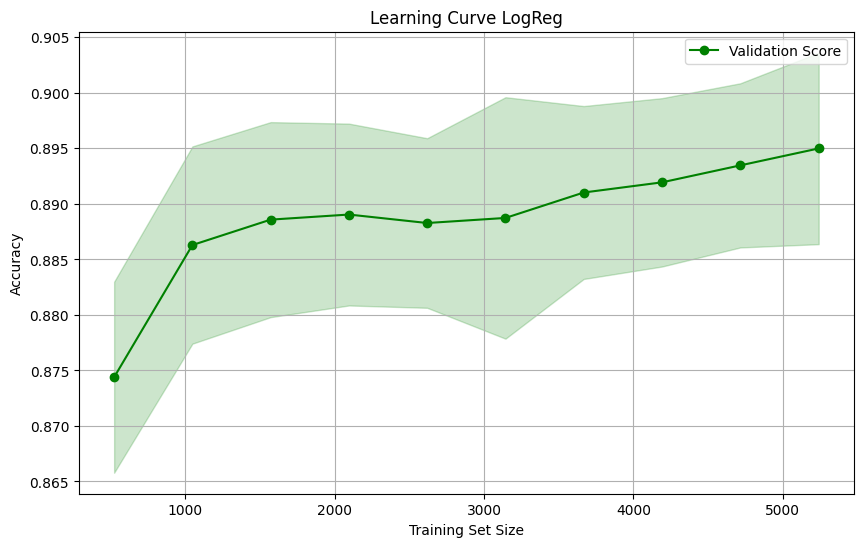

In [15]:
# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score")

# Fülle die Bereiche für Standardabweichung
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

# Plot-Konfiguration
plt.title("Learning Curve LogReg")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


The learning curve shows that the model suffers neither from overfitting nor from severe underfitting. It generalizes well, does not overperform.

### Removal of features with overpowered importance from feature_importance_analysis.ipynb

In [4]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df_improved = pd.read_csv(data_path)
df_improved = df_improved.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded']) 

# drop overpowered features
common_features = pd.read_csv("FeatureSelectionForDeletion/common_features.csv") 
features_to_drop = common_features["Common Features"].tolist()
df_improved = df_improved.drop(columns=features_to_drop, errors="ignore")

# set target
target = 'daytime_encoded'  # Zielvariable
X = df_improved.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df_improved[target]  # Zielvariable

# Train test Split
X_train_improved, X_test_improved, y_train_improved, y_test_improved = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train_improved.shape}, Testdaten: {X_test_improved.shape}")

Trainingsdaten: (6552, 49), Testdaten: (2809, 49)


### Feature selected Pipeline with Scaler, Cross Validation

In [13]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Schritt 2: Modell
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train_improved, y_train_improved, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train_improved, y_train_improved)

# Vorhersagen auf den Testdaten
y_pred_improved = pipeline.predict(X_test_improved)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("\nTestdaten-Auswertung:")
print(classification_report(y_test_improved, y_pred_improved, target_names= target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_improved, y_pred_improved))


Cross-Validation Accuracy Scores: [0.89702517 0.89092296 0.87557252 0.88931298 0.89083969]
Mean CV Accuracy: 0.8887346644074509

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.90      0.92      0.91      1642
           M       0.89      0.85      0.87      1167

    accuracy                           0.89      2809
   macro avg       0.89      0.89      0.89      2809
weighted avg       0.89      0.89      0.89      2809


Confusion Matrix:
 [[1517  125]
 [ 170  997]]


Feature selection was too much and performance decreased by over 2%. Consider to drop only the feature date_time_encoded, as it is most likely to imply data leakage.

### Adapt feature selection

In [25]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df_improved = pd.read_csv(data_path)
df_improved = df_improved.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded', 'date_time_encoded']) 

# set target
target = 'daytime_encoded'  # Zielvariable
X = df_improved.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df_improved[target]  # Zielvariable

# Train test Split
X_train_improved, X_test_improved, y_train_improved, y_test_improved = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train_improved.shape}, Testdaten: {X_test_improved.shape}")

Trainingsdaten: (6552, 56), Testdaten: (2809, 56)


In [15]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Schritt 2: Modell
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train_improved, y_train_improved, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train_improved, y_train_improved)

# Vorhersagen auf den Testdaten
y_pred_improved = pipeline.predict(X_test_improved)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("\nTestdaten-Auswertung:")
print(classification_report(y_test_improved, y_pred_improved, target_names= target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_improved, y_pred_improved))


Cross-Validation Accuracy Scores: [0.8993135  0.90846682 0.8870229  0.89694656 0.90229008]
Mean CV Accuracy: 0.8988079724701731

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.91      0.93      0.92      1642
           M       0.90      0.87      0.88      1167

    accuracy                           0.90      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.90      0.90      0.90      2809


Confusion Matrix:
 [[1529  113]
 [ 154 1013]]


Performance is slightly worse but model is more robust and less liekly to overfit. still good validation accuracy of 90%.

### Hyperparameter tuning with grid search

In [27]:
from sklearn.model_selection import GridSearchCV

# Pipeline mit StandardScaler und LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))  # Schritt 2: Logistic Regression
])

# Hyperparameter für GridSearch
param_grid = [
    {"classifier__C": [0.01, 0.1, 1, 10, 100, 1000], 
     "classifier__penalty": ["l2"], 
     "classifier__solver": ["lbfgs", "sag", "saga"]},

    {"classifier__C": [0.01, 0.1, 1, 10, 100, 1000], 
     "classifier__penalty": ["none"], 
     "classifier__solver": ["saga"]},

    {"classifier__C": [0.01, 0.1, 1, 10, 100, 1000], 
     "classifier__penalty": ["elasticnet"], 
     "classifier__l1_ratio": [0.1, 0.5, 0.9],  
     "classifier__solver": ["saga"]}
]



# GridSearchCV mit Cross-Validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                        # Anzahl der Cross-Validation-Folds
    scoring='accuracy',          # Metrik zur Bewertung
    n_jobs=-1,                   # Parallelisierung
    verbose=2                    # Fortschrittsanzeige
)

# GridSearchCV auf die Trainingsdaten anwenden
grid_search.fit(X_train_improved, y_train_improved)

# Beste Hyperparameter und Ergebnis anzeigen
print("Beste Hyperparameter:", grid_search.best_params_)
print("Beste Cross-Validation-Genauigkeit:", grid_search.best_score_)

# Pipeline mit den besten Parametern trainieren
best_pipeline = grid_search.best_estimator_

# Vorhersagen auf den Testdaten
y_pred_improved = best_pipeline.predict(X_test_improved)

# Ergebnisse auf Testdaten ausgeben
target_names = ['A', 'M']
print("\nTestdaten-Auswertung:")
print(classification_report(y_test_improved, y_pred_improved, target_names=target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_improved, y_pred_improved))


Fitting 5 folds for each of 42 candidates, totalling 210 fits
Beste Hyperparameter: {'classifier__C': 1, 'classifier__l1_ratio': 0.9, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Beste Cross-Validation-Genauigkeit: 0.8997237700956673

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.91      0.93      0.92      1642
           M       0.90      0.87      0.88      1167

    accuracy                           0.91      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.91      0.91      0.91      2809


Confusion Matrix:
 [[1530  112]
 [ 154 1013]]


### Model test with optimal hyperparameters and improved feature selection

Cross-Validation Accuracy Scores: [0.89778795 0.90083905 0.88167939 0.89160305 0.9       ]
Mean CV Accuracy: 0.8943818890072842
Standard Deviation CV Accuracy: 0.0071264972781234495

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.90      0.93      0.91      1642
           M       0.89      0.86      0.87      1167

    accuracy                           0.90      2809
   macro avg       0.90      0.89      0.89      2809
weighted avg       0.90      0.90      0.90      2809


Confusion Matrix:
 [[1519  123]
 [ 169  998]]


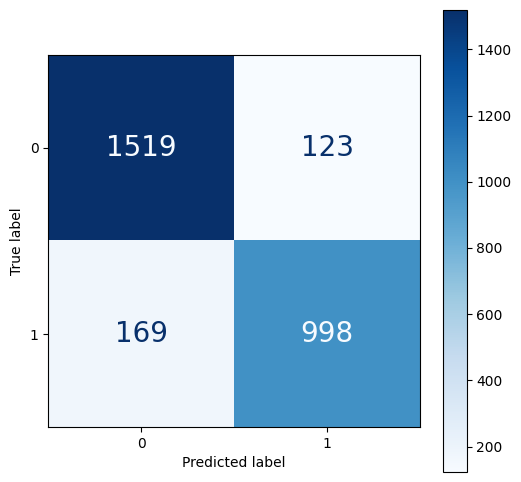

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', LogisticRegression( # Schritt 2: Modell 
    max_iter=2000, 
    C=1,       
    l1_ratio=0.9,           
    penalty='elasticnet',  
    solver='saga', 
    random_state=42 ))  
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train_improved, y_train_improved, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train_improved, y_train_improved)

# Vorhersagen auf den Testdaten
y_pred_improved = pipeline.predict(X_test_improved)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation CV Accuracy:", np.std(cv_scores))

print("\nTestdaten-Auswertung:")
print(classification_report(y_test_improved, y_pred_improved, target_names= target_names))
matrix = confusion_matrix(y_test_improved, y_pred_improved)
print("\nConfusion Matrix:\n",matrix )
display_cm_logreg = ConfusionMatrixDisplay(matrix)
fig, ax = plt.subplots(figsize=(6, 6))  # Größe des Plots anpassen
display_cm_logreg.plot(ax=ax, text_kw={"fontsize": 20}, cmap=plt.cm.Blues)  # Schriftgröße anpassen
plt.show()


### ROC Visualisation

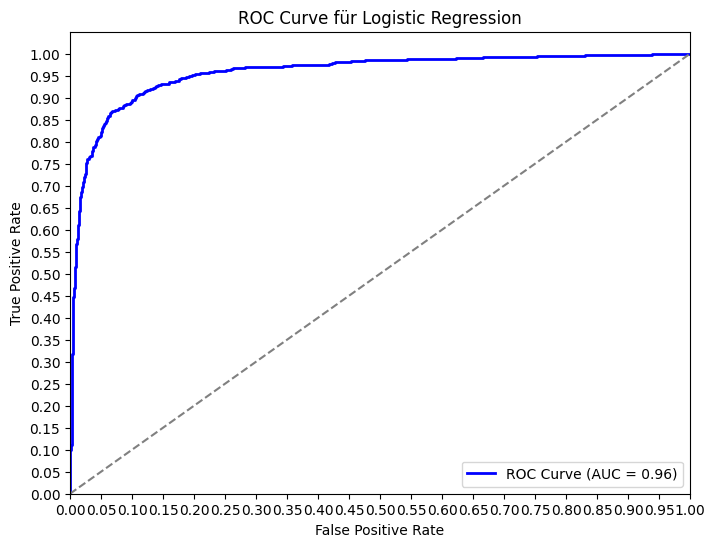

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Wahrscheinlichkeiten für die positive Klasse (M) vorhersagen
y_probs_improved = pipeline.predict_proba(X_test_improved)[:, 1]  # Nur Spalte für Klasse 1 (M)

# ROC-Kurve berechnen
fpr, tpr, thresholds = roc_curve(y_test_improved, y_probs_improved)

# AUC berechnen
auc_score = roc_auc_score(y_test_improved, y_probs_improved)

# ROC-Kurve plotten
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale Linie für Zufallsrate
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# Achsenbeschriftungen feinkörniger setzen
plt.xticks(np.arange(0.0, 1.05, 0.05))  # Schritte von 0.05 für X-Achse
plt.yticks(np.arange(0.0, 1.05, 0.05))  # Schritte von 0.05 für Y-Achse

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve für Logistic Regression')
plt.legend(loc='lower right')
plt.show()
